# Save Different Stages of the Chirp Sequence Pipeline as MAT Files

If you haven't gone through the `Walkthrough.ipynb` notebook, please take a look at that notebook first, as it contains descriptions of all configurable parameters used here.

In [5]:
import Pkg;
Pkg.develop(path="../BatlabJuliaUtils")
using BatlabJuliaUtils
using Plots;
using Printf;
using MAT;
using Statistics;
using DataStructures;

   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [f695e19e] + BatlabJuliaUtils v0.1.0 `../../../git-managed/batlab-chirp-processing/BatlabJuliaUtils`
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [f695e19e] + BatlabJuliaUtils v0.1.0 `../../../git-managed/batlab-chirp-processing/BatlabJuliaUtils`
  [d360d2e6] + ChainRulesCore v1.19.0
  [38540f10] + CommonSolve v0.2.4
  [a8cc5b0e] + Crayons v4.1.1
  [82cc6244] + DataInterpolations v4.6.0
  [e2d170a0] + DataValueInterfaces v1.0.0
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [08abe8d2] + PrettyTables v2.3.1
  [438e738f] + PyCall v1.96.4
  [d330b81b] + PyPlot v2.11.2
  [f2b01f46] + Roots v2.0.22
  [892a3eda] + StringManipulation v0.3.4
  [3783bdb8] + TableTraits v1.0.1
  [bd369af6] + Tables v1.11.1
Precompiling BatlabJuliaUtils
  ✓ IteratorInterfaceExtensions
  ✓ DataValueInterfaces
  ✓ CommonSolve
  ✓ TableTraits
  ✓ Crayons
  ✓ ChainRulesCore
  ✓ StringManipulation
  ✓ Tables
 

## Specify MAT Files

In [6]:
AUDIO_FILENAME = "../data/Pu166_01.mat";
CENTROID_FILENAME = "../data/centroid/Pu166_001_centroidxyz.mat";
MIC_POSITION_FILENAME = "../data/mic_positions_fall2021.mat";

CENTROID_VARIABLE_NAME = collect(keys(matread(CENTROID_FILENAME)))[1];
MIC_POSITION_VARIABLE_NAME = collect(keys(matread(MIC_POSITION_FILENAME)))[1];

In [7]:
(@printf "Do the variable names for these MAT files look right?\n\tFor the centroid file: \"%s\",\n\tand for the mic position file: \"%s\"" CENTROID_VARIABLE_NAME MIC_POSITION_VARIABLE_NAME)

Do the variable names for these MAT files look right?
	For the centroid file: "centroid_xyz_cted",
	and for the mic position file: "mic_pos1_2021"

If the variable names for the MAT files don't look right, then uncomment and run the following two cells.

In [ ]:
# println("The keys of the centroid file are:\n", keys(matread(CENTROID_FILENAME)), "\nand the MAT file looks like")
# centroids = matread(CENTROID_FILENAME)

In [ ]:
# println("The keys of the mic position file are:\n", keys(matread(MIC_POSITION_FILENAME)), "\nand the MAT file looks like")
# mic_locations = matread(MIC_POSITION_FILENAME)

## Set up where to save data

In [8]:
## Makes a new folder in the current directory to store the data
mkpath("saved_chirp_sequences");

Each function that saves data takes in the arguments `dataset_name` and `save_dir`, among others like the microphone and centroid data, _etc._
- `dataset_name` is the name of the dataset, e.g. `Pu166_01`. The name of any MAT file saved by this notebook will start with this dataset name.
- `save_dir` is the directory in which to save the data. A default directory was created in the cell above.

In [9]:
DATASET_NAME = "Pu166_01";
SAVE_DIR = "./saved_chirp_sequences";

## Read in microphone and centroid data

In [10]:
## Read in microphone data
y = readmicdata(AUDIO_FILENAME);

In [12]:
centroids = matread(CENTROID_FILENAME)[CENTROID_VARIABLE_NAME];
if size(centroids, 2) != 3
    centroids = Matrix(transpose(centroids));
end
mic_positions = matread(MIC_POSITION_FILENAME)[MIC_POSITION_VARIABLE_NAME];
if size(mic_positions, 2) != 3
    mic_positions = Matrix(transpose(mic_positions));
end

4×3 Matrix{Float64}:
  2911.36      -594.18   2267.79
  -599.596    -2886.39   2111.6
    -7.00515   2835.34   1442.65
 -2823.26       658.122  2326.58

## Stage 1: High-SNR Regions
**Note**: to run future sections, you need to run the **Parameters** and **Load Helper Functions** parts of previous sections, but you don't need to run the **Save Data** part of Stage 1 if you only want the output from Stage 2, _e.g._. Please do read through the description of the saved data for all stages, however, so that you can understand what is saved for each stage.

### Parameters (From `Walkthrough.ipynb`)

In [13]:
### SET THESE PARAMETERS ###
SIGNAL_THRESH = 30
MAXFILTER_LENGTH_MS = 0.1
MAXFILTER_LENGTH = Int64(round(MAXFILTER_LENGTH_MS / 1000 * FS));

MIN_PEAK_THRESH = 35;
SNR_DROP_THRESH = 20;
PEAK_SNR_THRESH_RADIUS = 2500;

TAIL_SNR_THRESH = 20;
TAIL_MAXFILTER_LENGTH = 50;
#############################
HIGH_SNR_PARAMS = Dict(
    :signal_thresh => SIGNAL_THRESH,
    :maxfilter_length => MAXFILTER_LENGTH,
    :min_peak_thresh => MIN_PEAK_THRESH,
    :snr_drop_thresh => SNR_DROP_THRESH,
    :peak_snr_thresh_radius => PEAK_SNR_THRESH_RADIUS,
    :tail_snr_thresh => TAIL_SNR_THRESH,
    :tail_maxfilter_length => TAIL_MAXFILTER_LENGTH
);

### Load Helper Functions

In [14]:
include("SaveHighSnrRegions.jl");

In [15]:
function getmicfield(mat_data, name_after_mic_k_, mic)
    return mat_data["mic_" * string(mic) * "_" * name_after_mic_k_];
end

getmicfield (generic function with 1 method)

### Save Data

In [16]:
savehighsnrregions(y, DATASET_NAME, SAVE_DIR; HIGH_SNR_PARAMS...);

### Breakdown of saved data
A mat file will be stored in `save_dir` from above, with the name format `{dataset_name}_high_snr_regions.mat` (for example. `Pu166_01_high_snr_regions.mat`).

In [17]:
filename_stage1 = (@sprintf "%s/%s_high_snr_regions.mat" SAVE_DIR DATASET_NAME)

"./saved_chirp_sequences/Pu166_01_high_snr_regions.mat"

In [18]:
saved_mat_data_stage1 = matreadsorted(filename_stage1)

SortedDict{Any, Any, Base.Order.ForwardOrdering} with 16 entries:
  "mic_1_data_per_high_snr_region"     => [-0.00246981 0.0071251 … -0.00278964 …
  "mic_1_high_snr_region_lengths"      => [2243, 1955, 2539, 2482, 2577, 2502, …
  "mic_1_high_snr_region_onsets_ms"    => [18.352, 98.7, 214.232, 372.108, 441.…
  "mic_1_snr_data_per_high_snr_region" => [29.7826 29.7834 … 29.9907 29.9695; 3…
  "mic_2_data_per_high_snr_region"     => [0.0222305; 0.0324657; … ; 0.0014402;…
  "mic_2_high_snr_region_lengths"      => 285
  "mic_2_high_snr_region_onsets_ms"    => 5474.38
  "mic_2_snr_data_per_high_snr_region" => [29.8206; 30.0927; … ; 18.1454; 18.15…
  "mic_3_data_per_high_snr_region"     => [-0.00334891 -0.0174218 … -0.00302908…
  "mic_3_high_snr_region_lengths"      => [1008, 764, 950, 1122, 942, 1800, 830…
  "mic_3_high_snr_region_onsets_ms"    => [8.356, 35.552, 88.62, 203.928, 231.3…
  "mic_3_snr_data_per_high_snr_region" => [29.9077 29.7956 … 29.8723 29.787; 30…
  "mic_4_data_per_high_snr_r

In [19]:
mics = Vector{Int}(undef, 0);
num_high_snr_regions_per_mic = Dict();
for key=keys(saved_mat_data_stage1)
    maybe_match = match(r"mic_(\d)_high_snr_region_onsets_ms", key);
    if isnothing(maybe_match)
        continue
    end
    mic = parse(Int64, maybe_match[1]);
    mics = vcat(mics, mic);
    num_high_snr_regions_per_mic[mic] = length(saved_mat_data_stage1[key]);
    @printf "***For mic %d, there were %d high-SNR regions found.***\n" mic length(saved_mat_data_stage1[key])
end
println("Mics that found high-SNR regions: ", mics)

***For mic 1, there were 137 high-SNR regions found.***
***For mic 2, there were 1 high-SNR regions found.***
***For mic 3, there were 257 high-SNR regions found.***
***For mic 4, there were 230 high-SNR regions found.***
Mics that found high-SNR regions: [1, 2, 3, 4]


**The variables in the mat file are**:
- `mic_k_data_per_high_snr_region`: array where each column is a different high-
    SNR region for microphone `k`. Zeros are added to the end of each column to make all columns
    the same length.
- `mic_k_high_snr_region_lengths`: length, in audio samples, of each high-SNR region.
- `mic_k_high_snr_region_onsets_ms`: time, in milliseconds since the beginning of
    the microphone data, that the high-SNR region starts.
- `mic_k_snr_data_per_high_snr_region`: SNR of each high-SNR region, in the same
    format as `mic_k_data_per_high_snr_region`.

`k` is the number of any microphone that found at least one high-SNR region.

**We can get the mic data for the `i`-th high-SNR region for microphone `k` as follows:**

In [24]:
k = 1; # SET TO THE MIC YOU WANT
i = 10; # SET TO WHICH HIGH-SNR REGION YOU WANT

@assert !isnothing(findfirst(mics .== k)) "Mic chosen didn't find any high-SNR regions!"
@assert i <=  num_high_snr_regions_per_mic[k] "k is larger than the number of high-SNR regions found!"

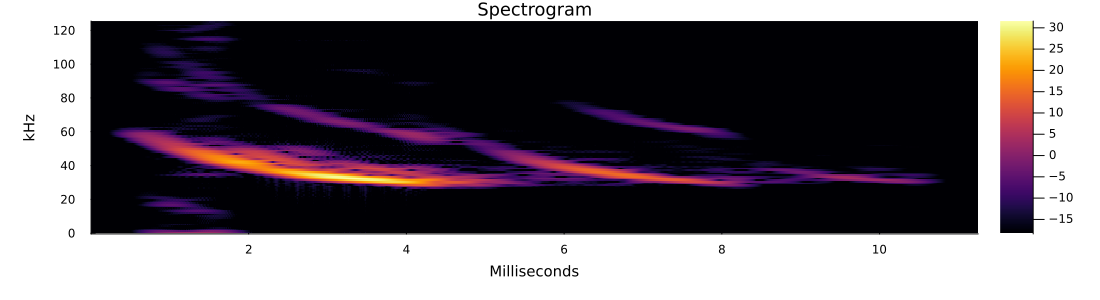

In [25]:
high_snr_region_length = getmicfield(saved_mat_data_stage1, "high_snr_region_lengths", k)[i];
mic_data = getmicfield(saved_mat_data_stage1, "data_per_high_snr_region", k);

## Remove extra zeros at the end!
mic_data = mic_data[1:high_snr_region_length, i]
plotSTFTtime(mic_data, noverlap=255)

### Save a Batch

The following cell saves the high-SNR regions for all Pu166 data. Expect to get the error `ErrorException("File ... does not exist and create was not specified")` for Pu166_06 and Pu166_13, as those datasets don't exist.

In [26]:
DATASET_NAMES = [(@sprintf "Pu166_%02d" i) for i=1:14];
AUDIO_FILENAMES = [(@sprintf "../data/Pu166_%02d.mat" i) for i=1:14];
save_dir = SAVE_DIR;

for (i, dataset_name)=enumerate(DATASET_NAMES)
    print("Saving high-SNR regions for ", dataset_name, "...");
    flush(stdout);

    try
        audio_filename = AUDIO_FILENAMES[i];
        mic_data = readmicdata(audio_filename);
        savehighsnrregions(mic_data, dataset_name, save_dir; HIGH_SNR_PARAMS...);
        println("ok");
    catch e
        if isa(e, InterruptException)
            println("\n\nCaught interrupt, exiting.");
            break;
        end
        println("\n\tERROR: ", e);
    end
    flush(stdout);
end
println("Done!")

Saving high-SNR regions for Pu166_01...ok
Saving high-SNR regions for Pu166_02...ok
Saving high-SNR regions for Pu166_03...ok
Saving high-SNR regions for Pu166_04...ok
Saving high-SNR regions for Pu166_05...ok
Saving high-SNR regions for Pu166_06...
	ERROR: ErrorException("File \"../data/Pu166_06.mat\" does not exist and create was not specified")
Saving high-SNR regions for Pu166_07...ok
Saving high-SNR regions for Pu166_08...ok
Saving high-SNR regions for Pu166_09...ok
Saving high-SNR regions for Pu166_10...ok
Saving high-SNR regions for Pu166_11...ok
Saving high-SNR regions for Pu166_12...ok
Saving high-SNR regions for Pu166_13...
	ERROR: ErrorException("File \"../data/Pu166_13.mat\" does not exist and create was not specified")
Saving high-SNR regions for Pu166_14...ok
Done!


## Stage 2: Chirp Sequences

### Parameters (From `Walkthrough.ipynb`)

In [28]:
### SET THESE PARAMETERS ###
TEMPORAL_TOLERANCE_MS = 2;
SINGLE_MIC_SNR_THRESH = 85; 
ANY_MIC_SNR_THRESH = 45; 
#############################
CHIRP_SEQ_PARAMS = Dict(
    :vocalization_start_tolerance_ms => TEMPORAL_TOLERANCE_MS,
    :single_mic_snr_thresh => SINGLE_MIC_SNR_THRESH,
    :any_mic_snr_thresh => ANY_MIC_SNR_THRESH,
    HIGH_SNR_PARAMS...
);

### Load Helper Functions

In [29]:
include("SaveChirpSequences.jl");

### Save Data

In [30]:
savechirpsequences(y, centroids, mic_positions, DATASET_NAME, SAVE_DIR; CHIRP_SEQ_PARAMS...);

In [31]:
filename_stage2 = (@sprintf "%s/%s_chirp_sequences.mat" SAVE_DIR DATASET_NAME)
saved_mat_data_stage2 = matreadsorted(filename_stage2)

SortedDict{Any, Any, Base.Order.ForwardOrdering} with 14 entries:
  "mic_1_chirp_seq_lengths"      => [2611, 3911, 3947, 0, 3717, 3611, 4074, 190…
  "mic_1_data_per_chirp_seq"     => [0.00360697 0.00360697 … -0.0181415 0.00488…
  "mic_1_snr_data_per_chirp_seq" => [29.5782 29.9793 … 29.9643 29.8311; 30.7514…
  "mic_2_chirp_seq_lengths"      => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, …
  "mic_2_data_per_chirp_seq"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; …
  "mic_2_snr_data_per_chirp_seq" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; …
  "mic_3_chirp_seq_lengths"      => [2963, 902, 4291, 1347, 760, 3636, 5206, 76…
  "mic_3_data_per_chirp_seq"     => [-0.0167821 0.00304784 … -0.00686713 -0.028…
  "mic_3_snr_data_per_chirp_seq" => [29.9187 29.8709 … 29.8 29.9634; 30.7191 30…
  "mic_4_chirp_seq_lengths"      => [1216, 1758, 985, 1698, 811, 1018, 1068, 51…
  "mic_4_data_per_chirp_seq"     => [0.0026227 -0.00346325 … -0.0252445 -0.0230…
  "mic_4_snr_data_per_chirp_seq" => [29.619

### Breakdown of saved data

**`vocalization_times`**: list of estimated times that the bat vocalized.

There were 53 vocalizations!


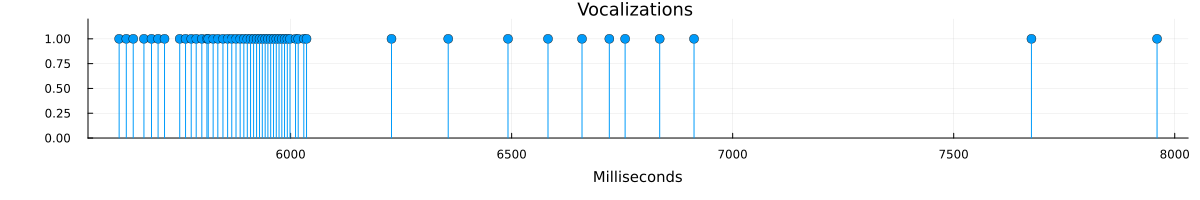

In [32]:
vocalization_times = saved_mat_data_stage2["vocalization_times"];
println("There were ", length(vocalization_times), " vocalizations!");
myplot(vocalization_times, ones(length(vocalization_times)), line=:stem, marker=:circle, color=:1, markersize=5,
    title="Vocalizations ", xlabel="Milliseconds", ylabel="", size=(1200, 200), yrange=(0, 1.2), legend=false)

**`valid_mics`**: matrix with N columns and 4 rows, where N is the total number of chirp sequences. Each column consists of 0s and 1s for whether each microphone heard anything for the chirp sequence corresponding to that column.

For instance, if `valid_mics` is
```
1   1   0   1   1
0   0   0   0   0
1   0   1   1   1
0   1   1   0   0
```
this means that the first vocalization was picked up by microphones 1 and 3, the second vocalization was picked up by microphones 1 and 4, the third was picked up by microphones 3 and 4, _etc._

In [33]:
valid_mics_stage2 = saved_mat_data_stage2["valid_mics"]

4×53 Matrix{Bool}:
 1  1  1  0  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  1  0     1  1  1  1  1  1  1  1  0  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     0  1  1  1  1  1  1  1  1  1  1  1

**Rest of the variables:**
- `mic_k_chirp_seq_lengths`: length, in samples, of the single-mic chirp sequence heard by microphone `k` for each vocalization. This will be `0` for vocalizations that mic `k` did not pick up.
- `mic_k_data_per_chirp_seq`: oscillogram data for the single-mic chirp sequence heard by microphone `k` for each vocalization. Zeros are added to the end of each column to make all columns the same length. This is all zeros for vocalizations that mic `k` did not pick up.
- `mic_k_snr_data_per_chirp_seq`: same as `mic_k_data_per_chirp_seq`, but SNR data instead of oscillogram data.

**Get microphone data for a vocalization**:

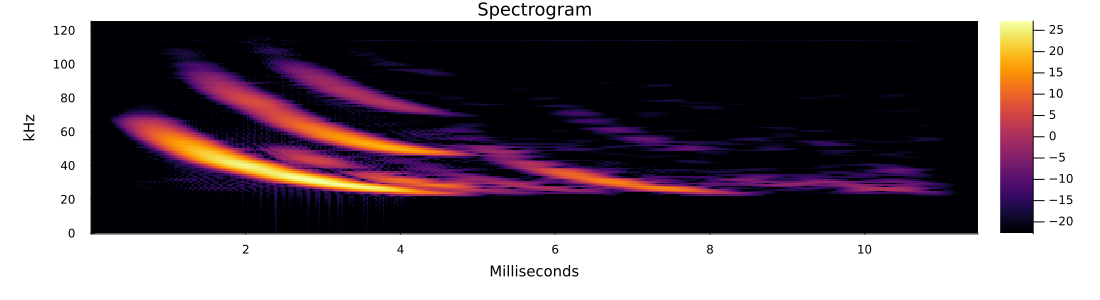

In [34]:
MIC = 1; ## Change this to any: 1, 2, 3, or 4 ##
CHIRP_NUM = 1; # You can change this too
if valid_mics_stage2[MIC, CHIRP_NUM] == 0
    println("Mic ", MIC, " did not hear vocalization ", CHIRP_NUM, ".");
else
    seq_length = getmicfield(saved_mat_data_stage2, "chirp_seq_lengths", MIC)[CHIRP_NUM];
    data = getmicfield(saved_mat_data_stage2, "data_per_chirp_seq", MIC)[1:seq_length, CHIRP_NUM];
    plotSTFTtime(data, noverlap=255)
end

# Save a Batch

This cell saves all chirp sequences for Pu166 data. Expect to get the error `ErrorException("File ... does not exist and create was not specified")` for Pu166_06 and Pu166_13, as those datasets don't exist.

To save outputs of stages 3 or 4 for all Pu166 data, you can copy this code and replace the `savechirpsequences` function call (the one with the comment above it) with a function call from a later section (e.g., `savechirpsandmelodies` or `saveoptimizationresult`). Make sure you pass in the right variables (e.g., `mic_data` instead of `y`, `centroid_data` instead of `centroids`, etc.)

In [35]:
DATASET_NAMES = [(@sprintf "Pu166_%02d" i) for i=1:14];
AUDIO_FILENAMES = [(@sprintf "../data/Pu166_%02d.mat" i) for i=1:14];
CENTROID_FILENAMES = [(@sprintf "../data/centroid/Pu166_%03d_centroidxyz.mat" i) for i=1:14];
mic_position_filename = "../data/mic_positions_fall2021.mat";
save_dir = SAVE_DIR;

for (i, dataset_name)=enumerate(DATASET_NAMES)
    print("Saving chirp sequences for ", dataset_name, "...");
    flush(stdout);

    try
        audio_filename = AUDIO_FILENAMES[i];
        centroid_filename = CENTROID_FILENAMES[i];
        mic_data = readmicdata(audio_filename);

        centroid_variable_name = collect(keys(matread(centroid_filename)))[1];
        mic_position_variable_name = collect(keys(matread(mic_position_filename)))[1];

        centroid_data = Matrix(transpose(matread(centroid_filename)[centroid_variable_name]));
        mic_position_data = Matrix(transpose(matread(mic_position_filename)[mic_position_variable_name]));

        ### YOU CAN REPLACE THIS WITH ANOTHER FUNCTION CALL TO SAVE DIFFERENT THINGS ###################################
        ### (e.g., chirps and melodies, or optimization outputs) #######################################################
        savechirpsequences(mic_data, centroid_data, mic_position_data, dataset_name, save_dir; CHIRP_SEQ_PARAMS...); ###
        ################################################################################################################
        println("ok");
    catch e
        if isa(e, InterruptException)
            println("\n\nCaught interrupt, exiting.");
            break;
        end
        println("\n\tERROR: ", e);
    end
    flush(stdout);
end
println("Done!")

Saving chirp sequences for Pu166_01...ok
Saving chirp sequences for Pu166_02...ok
Saving chirp sequences for Pu166_03...ok
Saving chirp sequences for Pu166_04...ok
Saving chirp sequences for Pu166_05...ok
Saving chirp sequences for Pu166_06...
	ERROR: ErrorException("File \"../data/Pu166_06.mat\" does not exist and create was not specified")
Saving chirp sequences for Pu166_07...ok
Saving chirp sequences for Pu166_08...ok
Saving chirp sequences for Pu166_09...ok
Saving chirp sequences for Pu166_10...ok
Saving chirp sequences for Pu166_11...ok
Saving chirp sequences for Pu166_12...ok
Saving chirp sequences for Pu166_13...
	ERROR: ErrorException("File \"../data/Pu166_13.mat\" does not exist and create was not specified")
Saving chirp sequences for Pu166_14...ok
Done!


## Stage 3: Chirps and Melodies

### Parameters (From `Walkthrough.ipynb`)

In [ ]:
### SET THESE PARAMETERS ###
MAXIMUM_MELODY_SLOPE = 5;
MELODY_DROP_THRESH_DB = 20;
FIND_HIGHEST_SNR_IN_FIRST_MS = 1.5;
MELODY_THRESH_DB_LOW = -20;
MOVING_AVG_SIZE = 10;
MELODY_DROP_THRESH_DB_START = 35; 
#############################
CHIRP_MELODY_PARAMS = Dict(
    :maximum_melody_slope => MAXIMUM_MELODY_SLOPE,
    :melody_drop_thresh_db => MELODY_DROP_THRESH_DB,
    :melody_thresh_db_low => MELODY_THRESH_DB_LOW,
    :moving_avg_size => MOVING_AVG_SIZE,
    :melody_drop_thresh_db_start => MELODY_DROP_THRESH_DB_START,
    :find_highest_snr_in_first_ms => FIND_HIGHEST_SNR_IN_FIRST_MS,
    CHIRP_SEQ_PARAMS...
);

### Load Helper Functions

In [ ]:
include("SaveChirpsAndMelodies.jl");

### Save Data

In [ ]:
savechirpsandmelodies(y, centroids, mic_positions, DATASET_NAME, SAVE_DIR; CHIRP_MELODY_PARAMS...);

In [ ]:
filename_stage3 = (@sprintf "%s/%s_chirps_and_melodies.mat" SAVE_DIR DATASET_NAME)
saved_mat_data_stage3 = matreadsorted(filename_stage3)

### Breakdown of saved data

**`valid_mics`**: exactly the same as in Stage 2.

**`highest_snr_estimated_chirp_per_chirp_seq`**: matrix where each column corresponds to a different bat vocalization. Each column contains the highest-SNR estimate of the bat vocalization for the corresponding multi-mic chirp sequence.

**`highest_snr_chirp_length_per_chirp_seq`**: length, in samples, of the chirps in `highest_snr_estimated_chirp_per_chirp_seq`.

**`highest_snr_melody_kHz_per_chirp_seq`**: matrix where each column corresponds to a different bat vocalization. Each column is the fundamental harmonic, in kHz, estimated using the corresponding column of `highest_snr_estimated_chirp_per_chirp_seq`.

**`updated_vocalization_times`**: now, we have a (hopefully) better estimate of when each bat vocalization happened.

**Rest of the variables:**

- `mic_k_chirp_lengths`: length, in samples, of the vocalization estimated by mic `k` for each multi-mic chirp sequence. This (and all subsequent variables lister here) will be `0` for vocalizations that mic `k` did not pick up.
- `mic_k_estimated_chirp_per_chirp_seq`: matrix where each column corresponds to a different bat vocalization. Each column contains the vocalization that mic `k` estimated for the corresponding multi-mic chirp sequence. 
- `mic_k_melody_kHz_per_chirp_seq`: matrix where each column corresponds to a different bat vocalization.  Each column is the fundamental harmonic, in kilohertz, estimated by mic `k`, of the bat vocalization. This will be the same length as `mic_k_estimated_chirp_per_chirp_seq`.
- `mic_k_samples_cut_off_from_beginning_per_chirp_seq`: The number of samples, if, any, were cut off from the beginning of the corresponding estimated chirp due to low SNR.

In [ ]:
updated_vocalization_times = saved_mat_data_stage3["updated_vocalization_times"];
println("There were ", length(updated_vocalization_times), " vocalizations!");
# myplot(updated_vocalization_times, ones(length(updated_vocalization_times)), line=:stem, marker=:circle, color=:1, markersize=5,
#     title="Vocalizations ", xlabel="Milliseconds", ylabel="", size=(1200, 200), yrange=(0, 1.2), legend=false)

**Get the estimated chirp and melody for a vocalization, using the highest-SNR data**:

In [ ]:
CHIRP_NUM = 8; # You can change this to look at another vocalization
len = saved_mat_data_stage3["highest_snr_chirp_length_per_chirp_seq"][CHIRP_NUM];
estimated_chirp = saved_mat_data_stage3["highest_snr_estimated_chirp_per_chirp_seq"][1:len, CHIRP_NUM];
estimated_melody_kHz = saved_mat_data_stage3["highest_snr_melody_kHz_per_chirp_seq"][1:len, CHIRP_NUM];

In [ ]:
plotSTFTtime(estimated_chirp, noverlap=255);
plot!(audioindextoms.((1:len) .+ 128), estimated_melody_kHz, linewidth=3, color=:blue)

## Stage 4: Optimized Chirps

**Note** this section is not for the impatient; it takes a long time to run the `saveoptimizationresults` cell.

### Parameters (From `Walkthrough.ipynb`)

In [ ]:
### SET THESE PARAMETERS ###
H_FFT_THRESH = 0.1;
DATA_FITTING_WEIGHT = 70;
H_SPARSITY_WEIGHT = 10;
MELODY_WEIGHT = 35;
MAX_ITER = 10000;
MELODY_RADIUS_START = 10;
MELODY_RADIUS_END = 0;
#############################
OPT_PARAMS = Dict(
    :h_fft_thresh => H_FFT_THRESH,
    :data_fitting_weight => DATA_FITTING_WEIGHT,
    :h_sparsity_weight => H_SPARSITY_WEIGHT,
    :melody_weight => MELODY_WEIGHT,
    :max_iter => MAX_ITER,
    :melody_radius_start => MELODY_RADIUS_START,
    :melody_radius_end => MELODY_RADIUS_END,
    CHIRP_MELODY_PARAMS...
);

### Load Helper Functions

In [ ]:
include("SaveOptimizationResult.jl");

In [ ]:
saveoptimizationresult(y, centroids, mic_positions, DATASET_NAME, SAVE_DIR; OPT_PARAMS...);

In [ ]:
filename_stage4 = (@sprintf "%s/%s_optimization_result.mat" SAVE_DIR DATASET_NAME)
saved_mat_data_stage4 = matreadsorted(filename_stage4)

### Breakdown of saved data

**`valid_mics`**: exactly the same as in Stage 2.

**`estimated_vocalizations`**: matrix where each column corresponds to a different bat vocalization. Each column is what the optimization algorithm estimates the bat vocalization to be.

**`estimated_vocalization_lengths`**: the estimated length, in microphone samples, of each bat vocalization.

**`mic_k_impulse_response_per_chirp_seq`**: matrix where each column corresponds to a different bat vocalization. Each column is the impulse response that maps the estimated vocalization to the corresponding microphone output. This is all zero if the microphone didn't pick up the vocalization.

**`impulse_response_lengths`**: the length of the impulse responses for each vocalization. The impulse response for each microphone has the same length.

**Get the estimated chirp for a vocalization**:

_Run the following cell once_:

In [ ]:
i = 0;

_Then run this cell again and again to loop through the vocalizations:_

In [ ]:
i = min(i+1, length(saved_mat_data_stage4["estimated_vocalization_lengths"]));
(@printf "Vocalization %d\n" i);
if i == length(saved_mat_data_stage4["estimated_vocalization_lengths"])
    println("(this is the last vocalization)");
end

CHIRP_NUM = i; # You can change this to look at another vocalization
len = saved_mat_data_stage4["estimated_vocalization_lengths"][CHIRP_NUM];
estimated_chirp = saved_mat_data_stage4["estimated_vocalizations"][1:len, CHIRP_NUM];
plotSTFTtime(estimated_chirp, noverlap=255)

**Compare with Highest-SNR Mic Output**

The top plot is the output of the optimization algorithm (should be de-echoed), and the bottom plot is what the highest-SNR microphone picked up.

In [ ]:
i = 0;

In [ ]:
i = min(i+1, length(saved_mat_data_stage4["estimated_vocalization_lengths"]));
(@printf "Vocalization %d\n" i);
if i == length(saved_mat_data_stage4["estimated_vocalization_lengths"])
    println("(this is the last vocalization)");
end

CHIRP_NUM = i; # You can change this to look at another vocalization
len = saved_mat_data_stage4["estimated_vocalization_lengths"][CHIRP_NUM];
estimated_chirp = saved_mat_data_stage4["estimated_vocalizations"][1:len, CHIRP_NUM];
chirp_init = saved_mat_data_stage3["highest_snr_estimated_chirp_per_chirp_seq"][1:len, CHIRP_NUM];
p1 = plotSTFTtime(estimated_chirp, noverlap=255, title="Optimized Vocalization Estimate");
p2 = plotSTFTtime(chirp_init, noverlap=255, title="Highest-SNR Mic Output");
plot(p1, p2, layout=(2, 1), size=(1100, 600))